## Abstract
Jak już wiemy podczas programowania rozwiązań problemu unsupervised learning'u z pewnością natkniemy się na implementacje algorytmu klasteryzującego nasze dane. Istnieje wiele algorytmów pozwalających nam na dokonanie takiej klasteryzacji, jednakże istnieje także wiele problemów w jej naturze. Niektóre algorytmy wymagają zgadnięcia lub podania liczby klastrów, coś co w większości przypadków z założenia nie wiemy, a inne nie działają dla specyficznych ułożeń danych. Dlatego w tym podejściu kluczowym jest wykonanie kilku różnych podejść i znalezienie optimum, lecz również trzeba mieć przy uwadze to by nie kierować się jedynie optymalizacją danego wskaźnika.  

Zacznijmy od pobrania wymaganych danych oraz bibliotek.

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
raw_data = pd.read_csv("clustering.csv",header = None)

In [2]:
#Zobaczmy jak prezentują się dane
raw_data

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186
...,...,...
395,22.423142,50.252807
396,-58.534367,-78.679387
397,36.446549,-11.841887
398,-101.284845,85.096034


Nasze dane są dość proste i nie posiadają interpretacji, ale niech nas to nie powstrzyma przed wypisaniem histogramów.

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

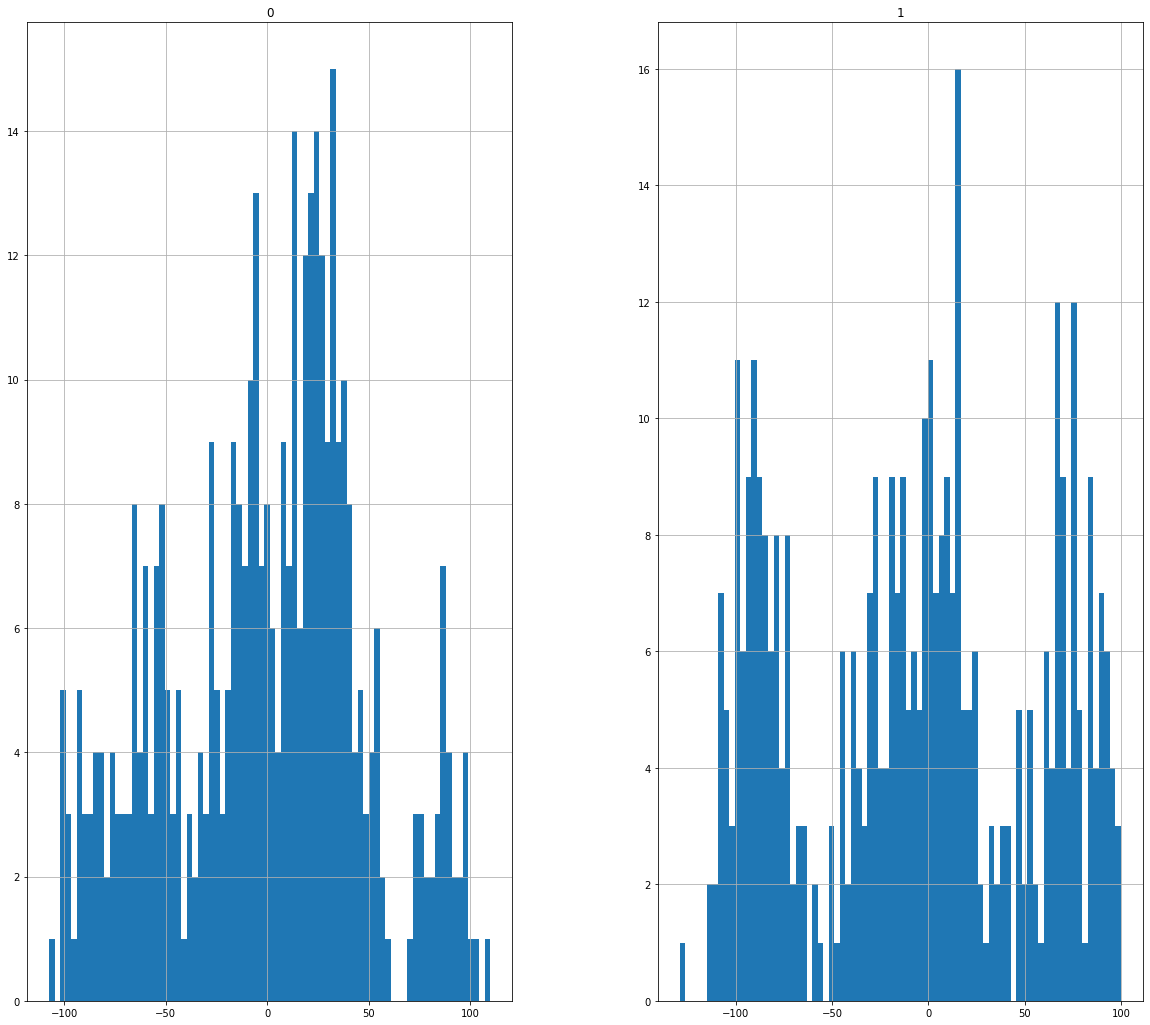

In [9]:
raw_data.hist(bins = 80,figsize = (20,18))

Już na histogramach widnieją pewne odosobnione "górnki" co już indykuje istnieje klastrów, dobra informacja.  
Dobrze, zobaczmy teraz meritum naszego zadania, wykonajmy scatterplot'a.

<AxesSubplot:xlabel='0', ylabel='1'>

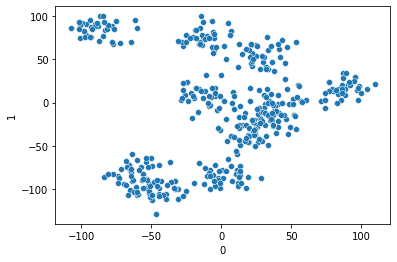

In [13]:
sns.scatterplot(x = raw_data.iloc[:,0],y=raw_data.iloc[:,1])

<AxesSubplot:xlabel='1', ylabel='0'>

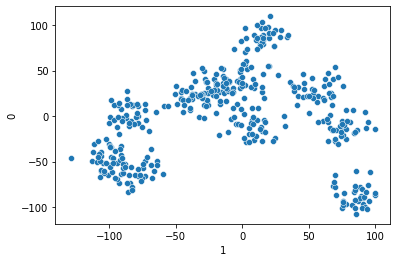

In [14]:
#Obrócony scatterplot
sns.scatterplot(y = raw_data.iloc[:,0],x=raw_data.iloc[:,1])

Na moje oko w zbiorze danych istnieje 8-9 klarownie rozpoznawalnych klastrów wedle mojej opinii. No dobrze zatem przekonajmy się co na ten temat mają do powiedzenia algorytmy.  
W wykonaniu zadania posłużyłem się materiałami umieszczonymi na repozytorium przedmiotu.

### Metoda k-średnich
Analizę rozpocznijmy od sprawdzenia metody k-średnich.

In [38]:
#Funkcja do wizualizacji z materiałów,lecz musiałem dokonać lekkiej modyfikacji by działała dla DataFrame
from sklearn.cluster import KMeans

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()
    
def plot_kmeans_clusters_n(X, n_clusters):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    for i in range(4):
        kmeans = KMeans(n_clusters=n_clusters[i], random_state=0)
        kmeans.fit(X)
        y_kmeans = kmeans.predict(X)
        ax[i].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=30, cmap='viridis')

        centers = kmeans.cluster_centers_
        ax[i].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
        ax[i].set_title('K-means clusters for k='+ str(n_clusters[i]))
    

Przed matematycznym sprawdzeniem "poprawnej" ilości klastrów, zobaczmy jak prezentowałyby się dane dla wartości 8-9.

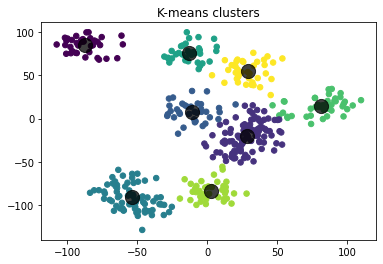

In [26]:
plot_kmeans_clusters(raw_data,8)

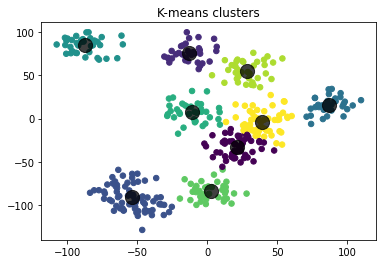

In [27]:
plot_kmeans_clusters(raw_data,9)

Jak widzimy dobór 8 bądź 9 klastrów wydaje się dość dobrym wyborem, a co się stanie jak wprowadzimy bardzo nietrafioną ilość klastrów? Sprawdźmy to, dla dobra nauki oczywiście.

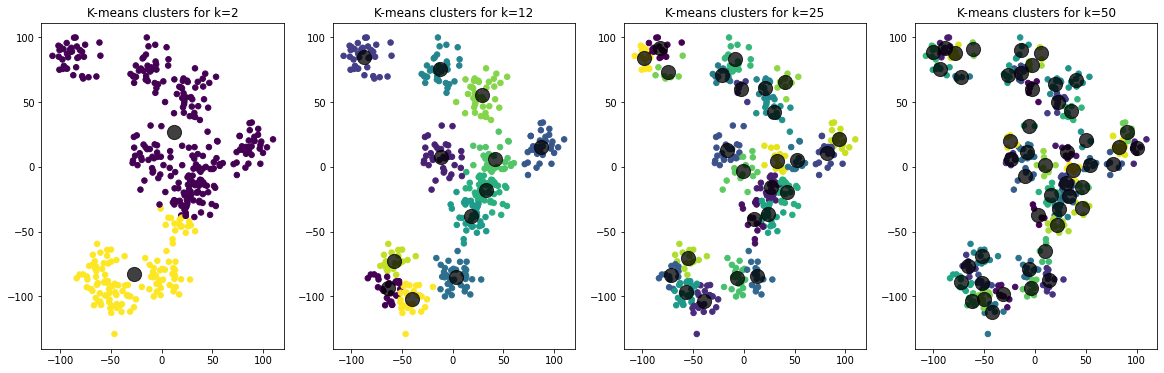

In [39]:
plot_kmeans_clusters_n(raw_data, [2,12,25,50])

Dość interesująco, choć algorytm poradził sobie bardzo dobrze z tym zadaniem.  
Lecz przejdźmy do zastosowania pewnej metryki w zagadnieniu klastrów, zastosujmy metodę Silhouette'a i przekonajmy się, ile klastrów powiniśmy wybrać.

In [46]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [58]:
def plot_silhouette(cluster_range,data):
    cluster_num_seq = cluster_range
    silhouette_vec = count_clustering_scores(data, cluster_num_seq, KMeans, silhouette_score)
    print("Optimal cluster number for k=", str(2 + silhouette_vec.index(max(silhouette_vec))))
    plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.show()

Optimal cluster number for k= 8


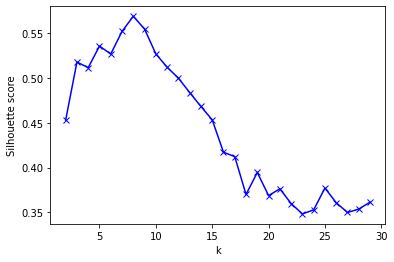

In [59]:
plot_silhouette(range(2,30),raw_data)

Jak widać moje przypuszczenia okazały się prawidłowe dla ośmiu klastrów w naszym zbiorze. Co więcej dla miary silhousette'a, jej jakość zwiększa się wraz ze wzrostem klastrów od pewnego punktu (u nas od k=27), przypominam, iż w tej metodzie doboru liczby skupień najlepszem wynikiem jest 1, a najgorszym -1.  
Lecz nadal mam niedosyt, zobaczmy co powie nam metoda łokcia dla tego zbioru.

In [60]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

In [61]:
def plot_elbow(cluster_max,data):
    wcss_vec = count_wcss_scores(data, cluster_max)
    x_ticks = list(range(1, len(wcss_vec) + 1))
    plt.plot(x_ticks, wcss_vec, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within-cluster sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

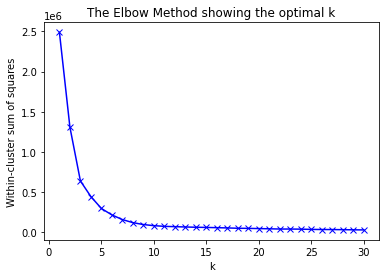

In [62]:
plot_elbow(30,raw_data)

Ta metoda również zwróciła podobne wyniki, chociaż ciężej jest stwierdzić, iż 8 jest naszym optimum.

## Metoda hierarchiczna
Wykonaliśmy metodę k-średnich, teraz zatem przyjdźmy do dokonania klasteryzacji metodą hierarchiczną, aglomeracyjną.  
Wypróbujmy kilka metryk doboru podziału do aglomeracji.

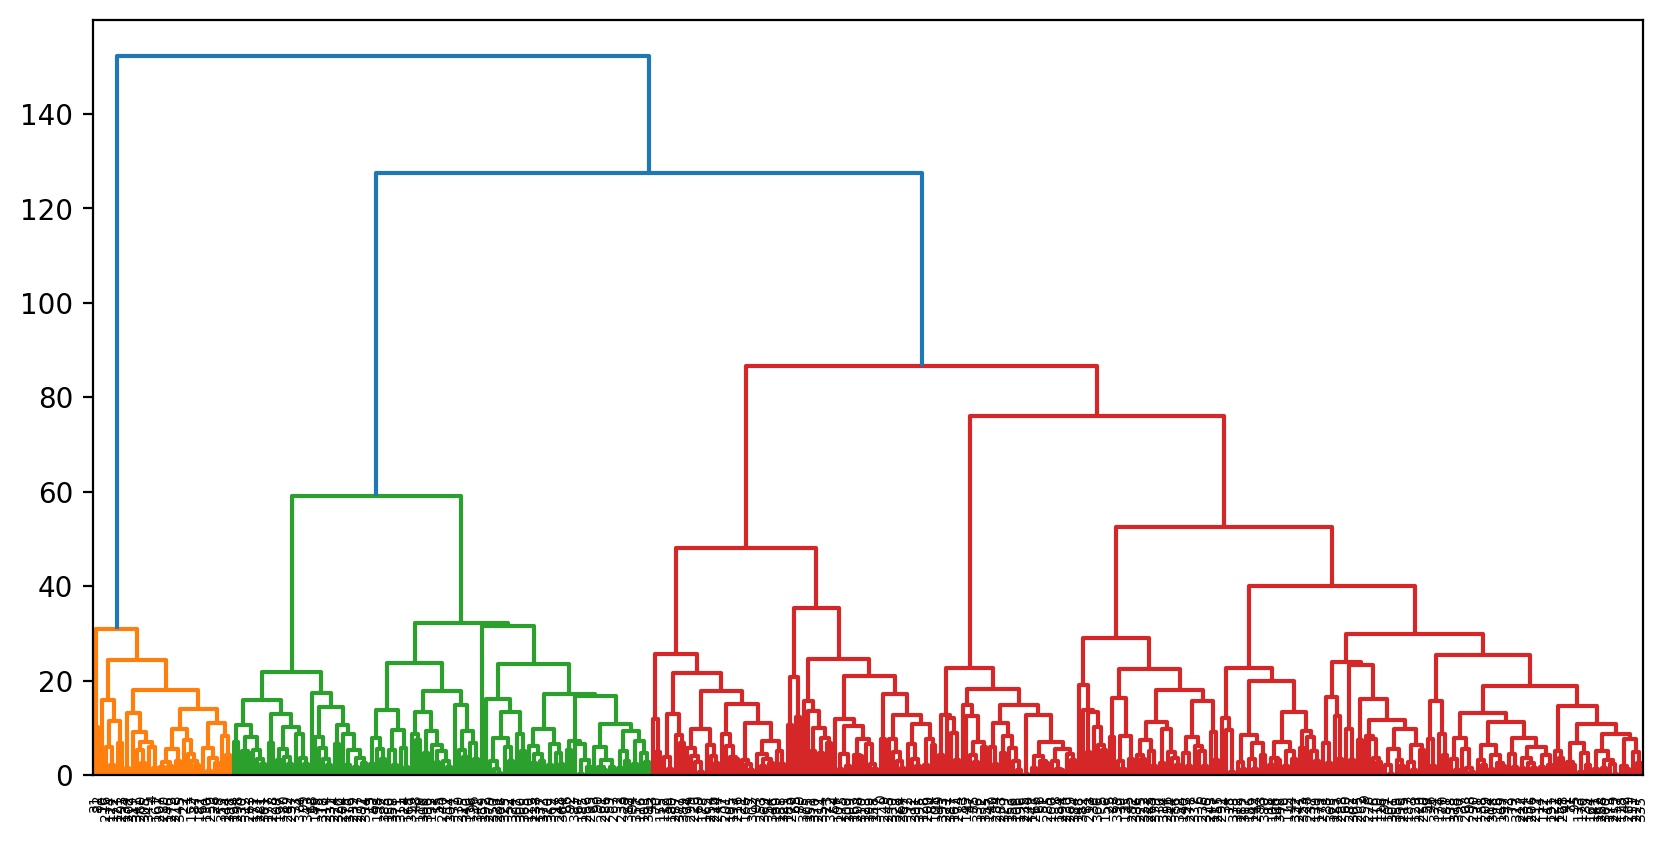

In [65]:
Z = hierarchy.linkage(raw_data, method='average')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

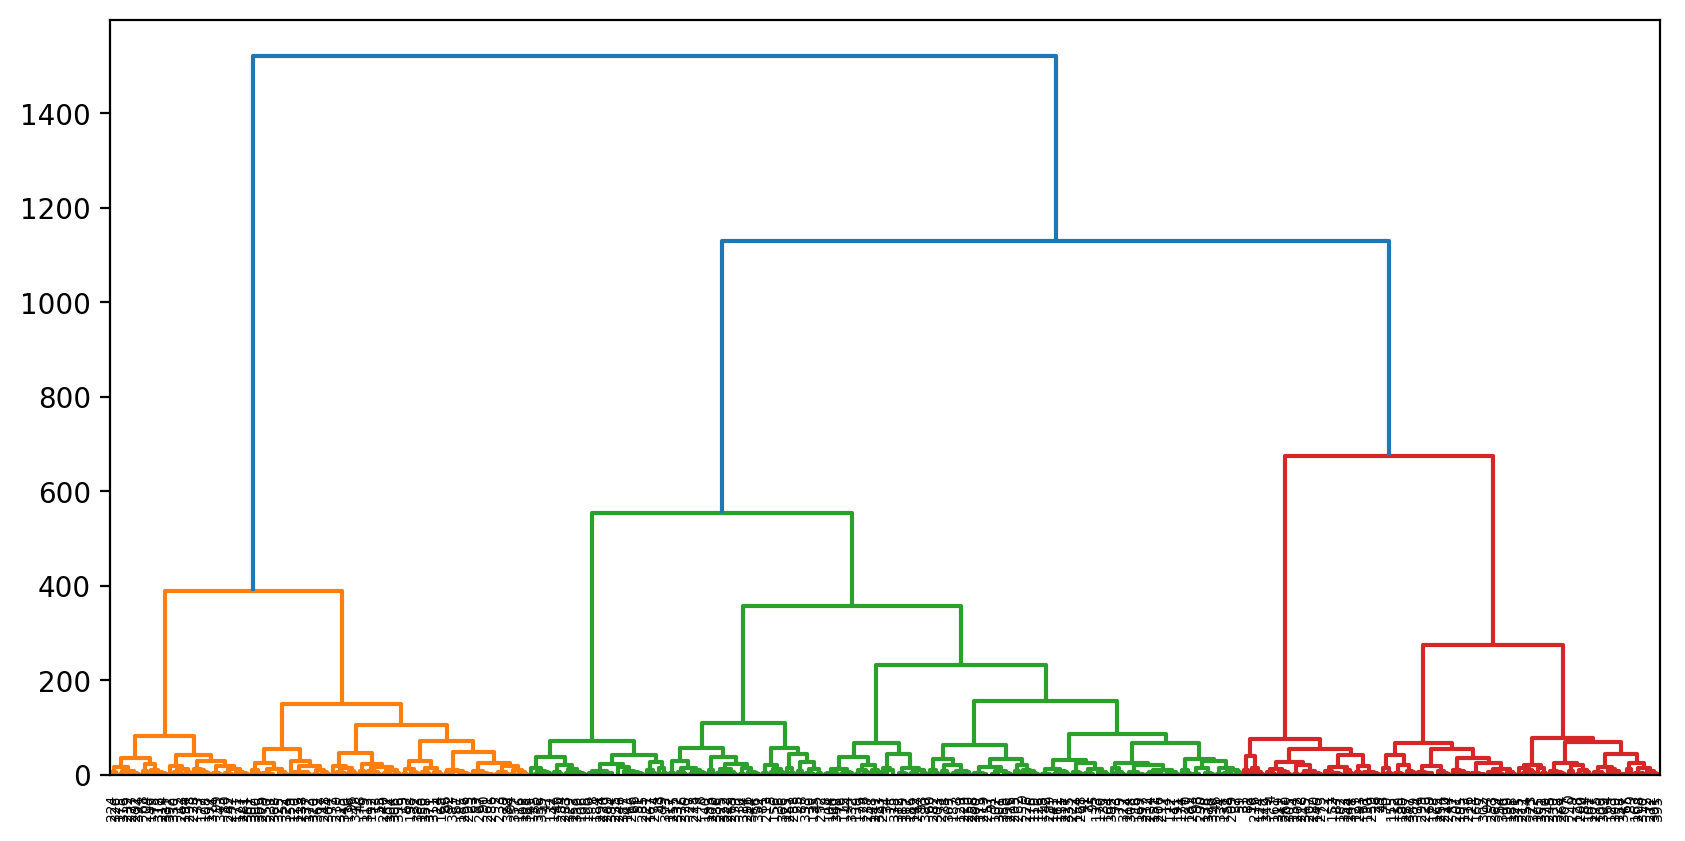

In [70]:
#Jak to będzie wyglądało dla innej metody połączenia?
Z = hierarchy.linkage(raw_data, method='ward')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

Wykonajmy teraz podobne sprawdzenie odpowiedniej ilości klastrów dla metody aglomeracyjnej, z tym wyjątkiem, iż teraz modyfikować będziemy nie n_clusters, lecz distahnce_threshold.

In [104]:
def plot_silhouette2(distance_range,data,linkage='average'):
    distance_num_seq = distance_range
    silhouette_vec =[]
    for dist in distance_range:
        model = AgglomerativeClustering(n_clusters=None, linkage=linkage, distance_threshold=dist)
        y = model.fit_predict(data)
        labels = model.fit_predict(data)
        k_num = silhouette_score(data,labels)
        silhouette_vec.append(k_num)
    print("Optimal cluster number for distance=", str(distance_num_seq[silhouette_vec.index(max(silhouette_vec))]))
    plt.plot(distance_num_seq, silhouette_vec, 'bx-')
    plt.xlabel('distance threshold')
    plt.ylabel('Silhouette score')
    plt.show()

Zobaczmy teraz zależność miary Silhouette'a w zależności od przyjętej przez nas odległośc, a potem zobaczmy samo klasterowanie.

Optimal cluster number for distance= 60


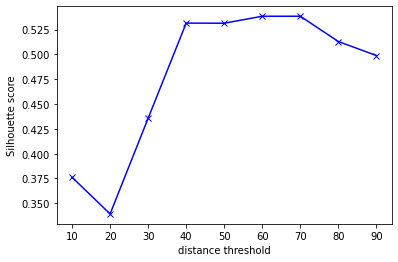

In [105]:
plot_silhouette2(range(10,100,10),raw_data,linkage='average')

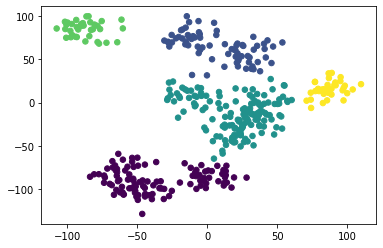

In [110]:
model = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=60)
y = model.fit_predict(raw_data)
plt.scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Nasze optimum zostało osiągnięte dla *distance_threshold* = 60, co przełożyło się na 5 klastrów, odrobinę mniej niż poprzednio, ale poeksperymentujmy trochę bardziej z metodą doboru łączenia klastrów. 

Optimal cluster number for distance= 80


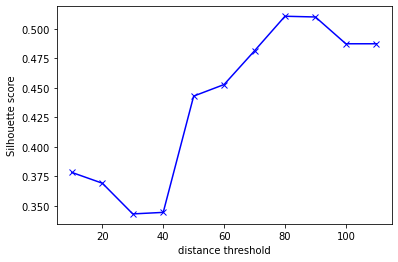

In [111]:
plot_silhouette2(range(10,120,10),raw_data,linkage='complete')

Optymalnym dystansem jest teraz 80, zobaczmy na jaki clustering się to przełoży.

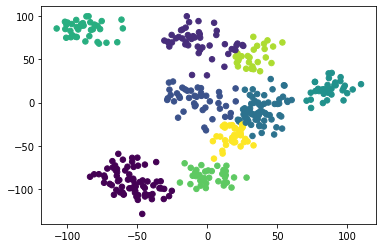

In [112]:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=80)
y = model.fit_predict(raw_data)
plt.scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Od razu lepiej, otrzymaliśmy clustering tak jak założyłem na początku, tudzież liczba naszych clustrów wynosi 9. No dobrzę, wypróbujmy jeszcze jendą metodę *linkage*, trochę bardziej orientalną, tudzież ward method i sprawdźmy wyniki.

Optimal cluster number for distance= 260


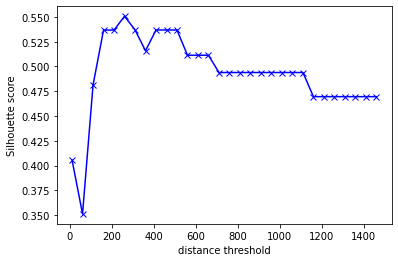

In [115]:
plot_silhouette2(range(10,1500,50),raw_data,linkage='ward')

Słowami wyjaśnienia, ponieważ w uprzednio wykonanym dendrycie można zauważyć dość spore wartości dla odległości w dla metody łączenia *ward*, zatem musiałem zwiększyć range i skok w nań, ale za to pięknie widać zmianę ilości klastrów wraz z progresem *distance threshold*, wykres wygląda jak przemiana fazowa dla pewnego ciała.  
Ok, potimum zostało osiągnięte dla 260, zobaczmy co się dzieje dla takiej wartości.

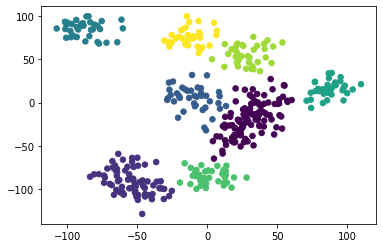

In [117]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=260)
y = model.fit_predict(raw_data)
plt.scatter(raw_data.iloc[:, 0], raw_data.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

W tym przypadku liczba optimum klastrów wynosi 8, czyli także tak jak przypuściłem na początku :D.

## Konkluzje

- Obydwie metody klastrowania zwróciły dla optymalnych ilości klastrów taką samą ich ilość, czyli 8 lub 9
- Miara Silhouette'a okazała się być bardziej klarowna w odczycie wyniku, niż użycie miary łokciowej
- Czas działania metody aglomeracyjnej był dłuższy niż czas działania metdoy k-średnich
- W metodzie aglomeracyjnej podawanie ilości klastrów a priori nie było klarowne, w szczególności znając graf dendrytyczny, lepiej było posłużyć się znajomością odległości międzyklastrowej, przez co optymalizacja została wydłużona ze względu na zwiększenie ilości prób dla różnych odległości
- Miary wyznaczania optimum klastrów (w szczególności Silhouette'a) nie działają liniowo i dla dużych wartości mogą zachodzić anomalie "polepszania się" wyników, coś na co trzeba potencjalnie uważać w doborze klastrów.